In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
df1 = pd.read_csv('./Data/Lab_Data/front_door_group_records.csv')
df2 = pd.read_csv('./Data/Lab_Data/back_door_group_records.csv')
df3 = pd.read_csv('./Data/Lab_Data/motion_group_records.csv')
# df4 = pd.read_csv('./Data/Lab_Data/actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
df3.loc[df3['sensor_name'] == 'Light Sensor', 'state'] = 1 - df3['state']

# combined_lab_data = pd.concat([df1, df2, df3], ignore_index=True)
combined_lab_data = pd.read_csv('./Data/Lab_Data/only_lab_dataset_07_02_2024.csv')
# Convert the 'datetime' column to a datetime data type if necessary
combined_lab_data['datetime'] = pd.to_datetime(combined_lab_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
combined_lab_data = combined_lab_data.sort_values(by='datetime')

# Display the sorted, combined DataFrame
# combined_lab_data.to_csv('./Data/Lab_Data/Combined_Lab_Data.csv')
print(combined_lab_data.head)

<bound method NDFrame.head of               date   time       seconds  state             sensor_name  \
0       2024-07-02  00:01  1.719896e+09    1.0  Lab Door Motion Sensor   
1       2024-07-02  00:01  1.719896e+09    0.0  Lab Door Motion Sensor   
2       2024-07-02  00:02  1.719897e+09    1.0  Lab Door Motion Sensor   
3       2024-07-02  00:02  1.719897e+09    0.0  Lab Door Motion Sensor   
4       2024-07-02  00:09  1.719897e+09    1.0  Lab Door Motion Sensor   
...            ...    ...           ...    ...                     ...   
213000  2024-10-18  10:31  1.729266e+09    1.0     Right Motion Sensor   
213001  2024-10-18  10:31  1.729266e+09    0.0     Right Motion Sensor   
213002  2024-10-18  10:32  1.729266e+09    1.0     Right Motion Sensor   
213003  2024-10-18  10:33  1.729266e+09    1.0     Right Motion Sensor   
213004  2024-10-18  10:34  1.729266e+09    0.0     Right Motion Sensor   

           thing_name       thing_ip                      datetime  
0         Fr

In [10]:
combined_lab_data = combined_lab_data.set_index('datetime') #make the date column as index

# combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
# print(combined_office_data.size, combined_office_data_filtered.size)
lab_hourly = combined_lab_data.state.resample('1h').sum() #resample on hourly basis and get summary of sensor values on 2 hours.

lab_hourly = lab_hourly.between_time('08:00', '18:00')
lab_hourly = lab_hourly.reset_index()
combined_lab_data = combined_lab_data.reset_index()

print(lab_hourly.head, combined_lab_data.head(10))

<bound method NDFrame.head of                 datetime  state
0    2024-07-02 08:00:00   31.0
1    2024-07-02 09:00:00   34.0
2    2024-07-02 10:00:00   36.0
3    2024-07-02 11:00:00   29.0
4    2024-07-02 12:00:00   33.0
...                  ...    ...
1191 2024-10-18 11:00:00    5.0
1192 2024-10-18 12:00:00    5.0
1193 2024-10-18 13:00:00   15.0
1194 2024-10-18 14:00:00   44.0
1195 2024-10-18 15:00:00   18.0

[1196 rows x 2 columns]>                        datetime        date   time       seconds  state  \
0 2024-07-02 05:01:14.632977486  2024-07-02  00:01  1.719896e+09    1.0   
1 2024-07-02 05:01:17.370395422  2024-07-02  00:01  1.719896e+09    0.0   
2 2024-07-02 05:02:14.967518568  2024-07-02  00:02  1.719897e+09    1.0   
3 2024-07-02 05:02:17.714888334  2024-07-02  00:02  1.719897e+09    0.0   
4 2024-07-02 05:09:14.637500048  2024-07-02  00:09  1.719897e+09    1.0   
5 2024-07-02 05:09:17.380526066  2024-07-02  00:09  1.719897e+09    0.0   
6 2024-07-02 05:12:38.680651665  20

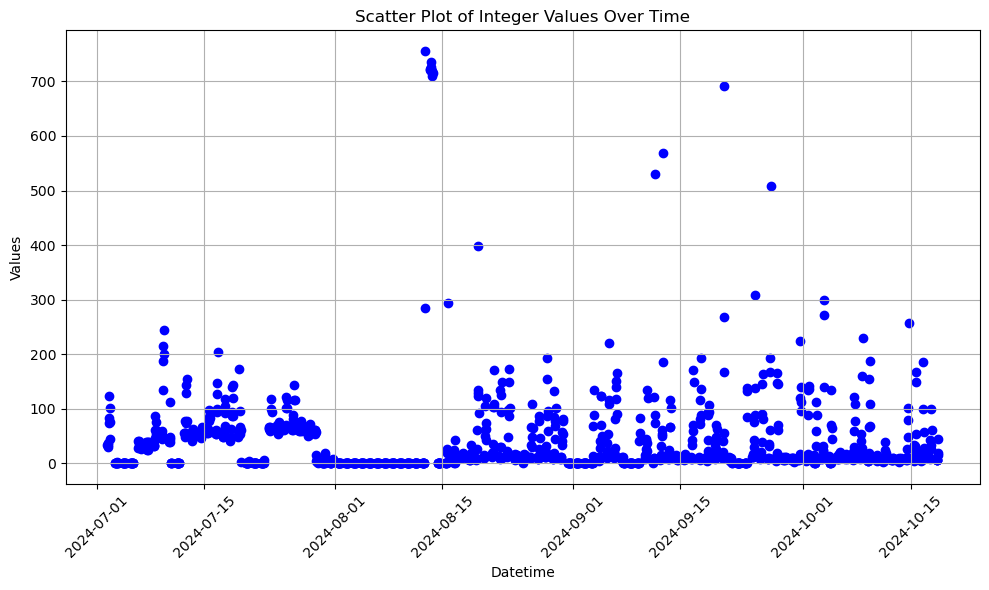

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(lab_hourly['datetime'], lab_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

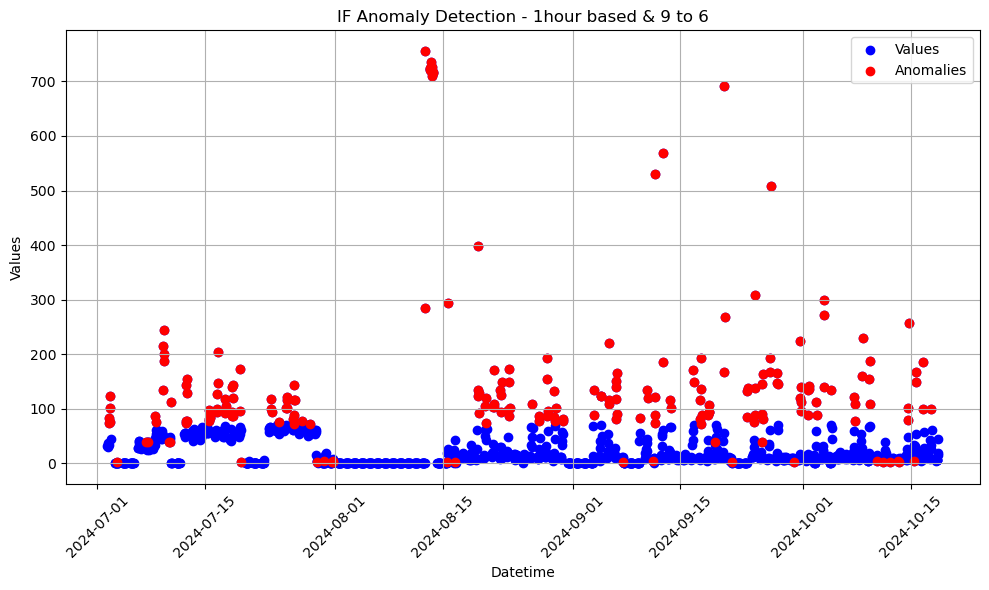

Total anomalies: 217, Percentage of anomalous values: 18.1438127090301%
                datetime  state  anomaly
0    2024-07-02 08:00:00   31.0        1
1    2024-07-02 09:00:00   34.0        1
2    2024-07-02 10:00:00   36.0        1
3    2024-07-02 11:00:00   29.0        1
4    2024-07-02 12:00:00   33.0        1
...                  ...    ...      ...
1191 2024-10-18 11:00:00    5.0        1
1192 2024-10-18 12:00:00    5.0        1
1193 2024-10-18 13:00:00   15.0        1
1194 2024-10-18 14:00:00   44.0        1
1195 2024-10-18 15:00:00   18.0        1

[644 rows x 3 columns]
                datetime  state  anomaly
0    2024-07-02 08:00:00   31.0        1
1    2024-07-02 09:00:00   34.0        1
2    2024-07-02 10:00:00   36.0        1
3    2024-07-02 11:00:00   29.0        1
4    2024-07-02 12:00:00   33.0        1
...                  ...    ...      ...
1191 2024-10-18 11:00:00    5.0        1
1192 2024-10-18 12:00:00    5.0        1
1193 2024-10-18 13:00:00   15.0        1
11

In [11]:
from sklearn.ensemble import IsolationForest

# lab_hourly['datetime'] = pd.to_datetime(lab_hourly['datetime'])

# Prepare data for IsolationForest
values = lab_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
lab_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = lab_hourly[lab_hourly['anomaly'] == -1]
non_anomalies = lab_hourly[lab_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(lab_hourly['datetime'], lab_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - 1hour based & 9 to 6')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_2H.png')
plt.show()


count_anomaly_h = (lab_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(lab_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

# non_anomalies.to_csv('./Output_CSV/regular_office.csv', index=False)
# anomalies.to_csv('./Output_CSV/anomaly_office.csv', index=False)
# lab_hourly.to_csv('./Output_CSV/lab_data/IF_lab_anomaly_1h_9to6.csv', index=False)

In [12]:
regular_date = non_anomalies.set_index('datetime')
regular_idx = regular_date.index
# print(regular_idx)

# Filtering out the hourly anomalous data from the original data
filtered_df = combined_lab_data[combined_lab_data.index.floor('h').isin(regular_idx)].reset_index()

# filtered_df = df[df.index.floor('H')]
print(filtered_df.sensor_name.unique(), combined_lab_data.sensor_name.unique())

AttributeError: 'RangeIndex' object has no attribute 'floor'

In [3]:
from math import ceil
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from neighbor_group import *
from sklearn.manifold import SpectralEmbedding

def frequent_next_event(df, adjacency_matrix):
    prev_row = df.iloc[0]
    for _,cur_row in df.iterrows():
        if (cur_row.sensor_name != prev_row.sensor_name):
            t = max(ceil(cur_row.seconds - prev_row.seconds), 1.0)
            # t = max(ceil((cur_row.DateTime - prev_row.DateTime).total_seconds()),1.0)
            adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
        prev_row = cur_row
    
    return adjacency_matrix

def time_delta(df, adjacency_matrix, th=2):
    cur_group = []
    prev_row = df.iloc[0]
    for _, cur_row in df.iterrows():
        if ((cur_row.seconds - prev_row.seconds) >= th):
            cur_group = []
        if not(cur_row.sensor_name in cur_group):
            cur_group.append(cur_row.sensor_name)
        for item in cur_group:
            adjacency_matrix[item][cur_row.sensor_name] += 1
        prev_row = cur_row
    
    return adjacency_matrix


def get_sensor_groups(adjacency_matrix):
    # Fixed cluster number
    n = 2
    max_ch = 0
    stop_iter = 10
    cluster_score_dict = {}
    patience = 0

    spectral_clustering = SpectralClustering(2, affinity="precomputed")
    cluster = spectral_clustering.fit_predict(adjacency_matrix)
    embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
        
    features = embedding.fit_transform(adjacency_matrix)

    ch_score = calinski_harabasz_score(features, cluster)
    silhouette_avg = silhouette_score(features, cluster)
    db_score = davies_bouldin_score(features, cluster)

    cluster_score_dict['cluster_number'] = 2
    cluster_score_dict['ch-score'] = ch_score
    cluster_score_dict['silhoutte-score'] = silhouette_avg
    cluster_score_dict['db-score'] = db_score
    cluster_score_dict['cluster'] = cluster
    print(cluster_score_dict)

    cluster_dict = get_cluster_sensor_list(cluster_score_dict['cluster'], adjacency_matrix)
    adjacency_matrix_list, unique_sensors = get_adjacency_matrix_list(cluster_dict, adjacency_matrix)

    # Get groups based on fixed nearest nodes
    sensor_group = {}
    sensor_number_each_group = 3  # Select the sensor numbers that will used to pick top nearest nodes
    i = 1 
    for index, matrix in enumerate(adjacency_matrix_list):
        groups = get_groups(matrix, sensor_number_each_group, unique_sensors[index])
        for group in groups:
            item_list = []
            for item in group:
                item_list.append(item)
            sensor_group['G'+ str(i)] = item_list
            i += 1

    # sensor_group_df = pd.DataFrame(sensor_group)
    print(sensor_group)
    return cluster_score_dict

In [5]:
unique_sensor = combined_lab_data.sensor_name.unique()

fnq_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix = frequent_next_event(combined_lab_data, fnq_adjacency_matrix)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
td_adjacency_matrix = time_delta(combined_lab_data, td_adjacency_matrix)
print('---------------------------')
print('Time Delta ends')



Frequent next event starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31524\2743512419.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t


---------------------------
Frequent next event ends
Time Delta starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31524\2743512419.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[item][cur_row.sensor_name] += 1


---------------------------
Time Delta ends


In [6]:
fne_scores = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix)

print("~~~ Time Delta results ~~~")

td_scores = get_sensor_groups(td_adjacency_matrix)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anacon

{'cluster_number': 2, 'ch-score': 21.015673384396532, 'silhoutte-score': 0.7013340754251104, 'db-score': 0.32331107133211073, 'cluster': array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1])}
['Lab Door Motion Sensor', 'Sonar Sensor', 'Lab Door Sensor', 'Right Motion Sensor', 'Left Motion Sensor', 'Lab Light Sensor', 'Front Motion Sensor']
['Back Door Sensor', 'Vibration Sensor', 'Back Motion Sensor']
number of unique group  5
('Front Motion Sensor', 'Lab Door Motion Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Right Motion Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Lab Light Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Lab Door Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Left Motion Sensor', 'Sonar Sensor')
number of unique group  1
('Back Door Sensor', 'Back Motion Sensor', 'Vibration Sensor')
{'G1': ['Front Motion Sensor', 'Lab Door Motion Sensor', 'Sonar Sensor'], 'G2': ['Lab Door Motion Sensor', 'Right Motion Sensor', 'Sonar Sensor'], 'G3': ['Lab Door Motion Sen

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [13]:
def anomaly_detection_and_removal(df, timeWindow = 'h'):
    df = df.set_index('datetime') #make the date column as index

    # combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
    # print(combined_office_data.size, combined_office_data_filtered.size)
    df_hourly = df.state.resample(timeWindow).sum() #resample on hourly basis and get summary of sensor values on 2 hours.

    df_hourly = df_hourly.between_time('08:00', '18:00')
    df_hourly = df_hourly.reset_index()
    
    values = df_hourly[['state']]  # Selecting the 'values' column as input for the model

    # Initialize and fit the IsolationForest model
    model = IsolationForest(contamination='auto', random_state=42)
    df_hourly['anomaly'] = model.fit_predict(values)

    # Isolation Forest outputs:
    # -1 for anomalies
    #  1 for normal data points

    # Filter the anomalies
    # anomalies = lab_hourly[lab_hourly['anomaly'] == -1]
    regular = df_hourly[df_hourly['anomaly'] == 1]
    

    regular_date = regular.set_index('datetime')
    regular_idx = regular_date.index
    # print(regular_idx)

    # Filtering out the hourly anomalous data from the original data
    filtered_df = df[df.index.floor(timeWindow).isin(regular_idx)].reset_index()
    return filtered_df

In [14]:
unique_sensor = combined_lab_data.sensor_name.unique()

fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

fd = anomaly_detection_and_removal(combined_lab_data, 'h')
print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix_filtered = frequent_next_event(fd, fnq_adjacency_matrix_filtered)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
td_adjacency_matrix_filtered = time_delta(fd, td_adjacency_matrix)
print('---------------------------')
print('Time Delta ends')

Frequent next event starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31524\2743512419.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t


---------------------------
Frequent next event ends
Time Delta starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31524\2743512419.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[item][cur_row.sensor_name] += 1


---------------------------
Time Delta ends


In [15]:
fne_scores_filtered = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix_filtered)

print("~~~ Time Delta results ~~~")

td_scores_filtered = get_sensor_groups(td_adjacency_matrix_filtered)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anacon

{'cluster_number': 2, 'ch-score': 37.941983152338125, 'silhoutte-score': 0.7493481543505089, 'db-score': 0.2699298001501717, 'cluster': array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0])}
['Lab Door Motion Sensor', 'Sonar Sensor', 'Lab Door Sensor', 'Right Motion Sensor', 'Left Motion Sensor', 'Lab Light Sensor', 'Front Motion Sensor']
['Back Door Sensor', 'Vibration Sensor', 'Back Motion Sensor']
number of unique group  5
('Front Motion Sensor', 'Lab Door Motion Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Right Motion Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Lab Light Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Lab Door Sensor', 'Sonar Sensor')
('Lab Door Motion Sensor', 'Left Motion Sensor', 'Sonar Sensor')
number of unique group  1
('Back Door Sensor', 'Back Motion Sensor', 'Vibration Sensor')
{'G1': ['Front Motion Sensor', 'Lab Door Motion Sensor', 'Sonar Sensor'], 'G2': ['Lab Door Motion Sensor', 'Right Motion Sensor', 'Sonar Sensor'], 'G3': ['Lab Door Motion Sens

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


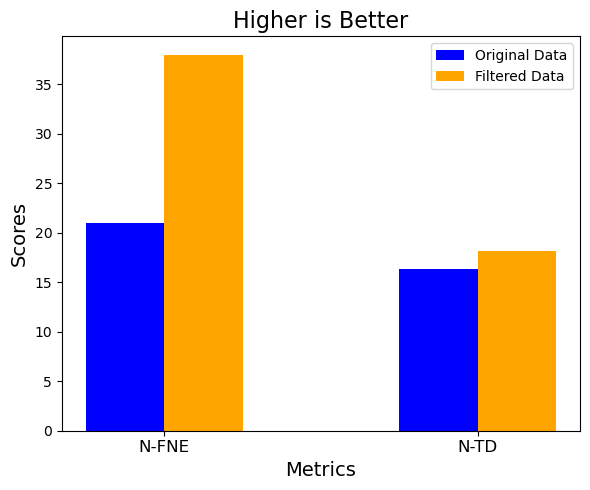

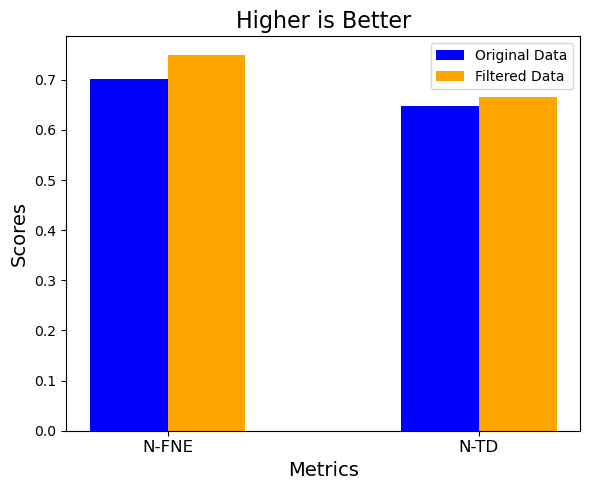

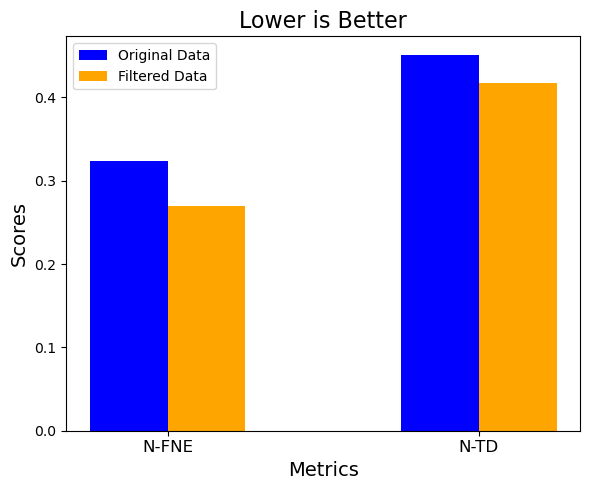

In [16]:
import numpy as np
def get_scores_plots(metrics, originalScores, filteredScores, title = 'Comparison of different Scores of Two Datasets for Two Algorithms'):
    # Set up the bar plot
    x = np.arange(2)  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot bars for each dataset
    bars1 = ax.bar(x - width/2, originalScores, width, label='Original Data', color='blue')
    bars2 = ax.bar(x + width/2, filteredScores, width, label='Filtered Data', color='orange')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)
    ax.set_title(title,  fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(["N-FNE", "N-TD"], fontsize=12)
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig(f"{metrics}.png", dpi=300)
    plt.show()

get_scores_plots(metrics = "./Plots/Lab_plots/lab_CH", originalScores= [fne_scores['ch-score'], td_scores['ch-score']], filteredScores= [fne_scores_filtered['ch-score'], td_scores_filtered['ch-score']], title= 'Higher is Better')
get_scores_plots(metrics = "./Plots/Lab_plots/lab_SH", originalScores= [fne_scores['silhoutte-score'], td_scores['silhoutte-score']], filteredScores= [fne_scores_filtered['silhoutte-score'], td_scores_filtered['silhoutte-score']], title= 'Higher is Better')
get_scores_plots(metrics = "./Plots/Lab_plots/lab_DB", originalScores= [fne_scores['db-score'], td_scores['db-score']], filteredScores= [fne_scores_filtered['db-score'], td_scores_filtered['db-score']], title= 'Lower is Better')


In [17]:
perc_CH_FNE = (fne_scores_filtered['ch-score'] - fne_scores['ch-score'])/fne_scores['ch-score'] *100
perc_SH_FNE = (fne_scores_filtered['silhoutte-score'] - fne_scores['silhoutte-score'])/fne_scores['silhoutte-score'] *100
perc_DB_FNE = (fne_scores_filtered['db-score'] - fne_scores['db-score'])/fne_scores['db-score'] *100

print(perc_CH_FNE, perc_SH_FNE, perc_DB_FNE)

perc_CH_TD = (td_scores_filtered['ch-score'] - td_scores['ch-score'])/td_scores['ch-score'] *100
perc_SH_TD = (td_scores_filtered['silhoutte-score'] - td_scores['silhoutte-score'])/td_scores['silhoutte-score'] *100
perc_DB_TD = (td_scores_filtered['db-score'] - td_scores['db-score'])/td_scores['db-score'] *100

print(perc_CH_TD, perc_SH_TD, perc_DB_TD)

80.54136290730916 6.846106671245803 -16.510808294314444
11.179354798058894 2.8182834997952937 -7.377705949112827


In [1]:
def anomaly_detection_and_removal(df, timeWindow = 'h'):
    df = df.set_index('datetime') #make the date column as index

    # combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
    # print(combined_office_data.size, combined_office_data_filtered.size)
    df_hourly = df.state.resample(timeWindow).sum() #resample on hourly basis and get summary of sensor values on 2 hours.

    df_hourly = df_hourly.between_time('09:00', '18:00')
    df_hourly = df_hourly.reset_index()
    
    values = df_hourly[['state']]  # Selecting the 'values' column as input for the model

    # Initialize and fit the IsolationForest model
    model = IsolationForest(contamination='auto', random_state=42)
    df_hourly['anomaly'] = model.fit_predict(values)

    # Isolation Forest outputs:
    # -1 for anomalies
    #  1 for normal data points

    # Filter the anomalies
    # anomalies = lab_hourly[lab_hourly['anomaly'] == -1]
    regular = df_hourly[df_hourly['anomaly'] == 1]
    

    regular_date = regular.set_index('datetime')
    regular_idx = regular_date.index
    # print(regular_idx)

    # Filtering out the hourly anomalous data from the original data
    filtered_df = df[df.index.floor(timeWindow).isin(regular_idx)].reset_index()
    return filtered_df

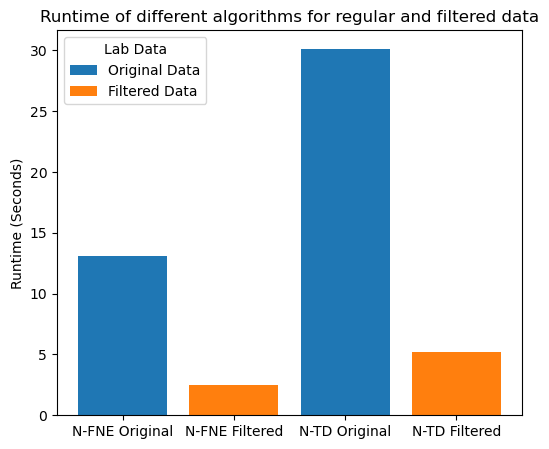

: 

In [ ]:
import time

fnq_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

runtimes = []
functions = ['N-FNE Original', 'N-FNE Filtered', 'N-TD Original', 'N-TD Filtered']

# # Runtime for FNE original data
# start_time = time.time()
# frequent_next_event(combined_lab_data, fnq_adjacency_matrix)
# end_time = time.time()

# runtime1 = end_time - start_time
# runtimes.append(runtime1)

# # Runtime for FNE filtered data
# start_time = time.time()
# fd = anomaly_detection_and_removal(combined_lab_data, 'h')
# frequent_next_event(fd, fnq_adjacency_matrix_filtered)
# end_time = time.time()

# runtime2 = end_time - start_time
# runtimes.append(runtime2)

# # Runtime for TD original Data
# start_time = time.time()
# time_delta(combined_lab_data, td_adjacency_matrix)
# end_time = time.time()

# runtime3 = end_time - start_time
# runtimes.append(runtime3)

# # Runtime for TD filtered data
# start_time = time.time()
# fd2 = anomaly_detection_and_removal(combined_lab_data, 'h')
# time_delta(fd2, td_adjacency_matrix_filtered)
# end_time = time.time()

# runtime4 = end_time - start_time
# runtimes.append(runtime4)

# print(runtimes)

runtimes = [13.089284420013428, 2.487198829650879, 30.147459506988525, 5.232787370681763]

fig, ax = plt.subplots(figsize=(6, 5))
bar_labels = ['Original Data', 'Filtered Data', '_Original Data', '_Filtered Data']
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']

ax.bar(functions, runtimes, label=bar_labels, color=bar_colors)

ax.set_ylabel('Runtime (Seconds)')
ax.set_title('Runtime of different algorithms for regular and filtered data')
ax.legend(title='Lab Data')

plt.savefig("./Plots/Lab_plots/lab_runtime.png", dpi=300)

plt.show()